Este agarra los datos del csv con la matriz de grayscale de cada espectrograma, y se los pasa al modelo de CNN de PyTorch (definido en aux file models.py), los guarda para poder llamarlo sin re-entrenar desde otros archivos

In [15]:
import os, sys
import pandas as pd
import numpy as np
import cupy as cp
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils import util, models

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(device))
else:
    print("CUDA not available")

Using device: cuda
NVIDIA GeForce RTX 5080


In [5]:
# UNCOMMENT THE ONE BEING USED

# NOT NOISE-REDUCED
df = pd.read_csv(os.path.join('..', 'database', 'meta', 'final', 'train_data.csv'))

# NOISE-REDUCED
# df = pd.read_csv(os.path.join('..', 'database', 'meta', 'final', 'train_data2.csv'))

In [6]:
# Extract labels and pixel values
labels = df['label'].values.astype(np.int64)
features = df.drop(columns=['label']).values.astype(np.float32)
features /= 255.0
# features = features.reshape(-1, 1, 313, 224) # TODO Try Uncommenting Me and comment the line below instead
features = features.reshape(-1, 1, 224, 313)

In [12]:
print("features shape:", features.shape)
print("labels shape:", labels.shape)

features shape: (3070, 1, 224, 313)
labels shape: (3070,)


In [16]:
# 1. Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    features, labels, test_size=0.2, stratify=labels, random_state=42
)

# 2. Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor   = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val, dtype=torch.long)

# 3. Create datasets and dataloaders
batch_size = 32

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
import importlib
importlib.reload(models)

Reset the Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from utils import models  # adjust if your path is different

def reset_model(lr=0.001, num_classes=28):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = models.BirdCNN(num_classes=num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    return model, optimizer, criterion, device

# Usage:
model, optimizer, criterion, device = reset_model()

Run to Train

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.BirdCNN(num_classes=28).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    train_losses.append(running_loss / total)
    train_accuracies.append(correct / total)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)

    val_losses.append(val_loss / val_total)
    val_accuracies.append(val_correct / val_total)

    print(f"Epoch {epoch+1}/{num_epochs} | "
        f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]*100:.2f}% | "
        f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]*100:.2f}%")


Epoch 1/20 | Train Loss: 5.4571, Train Acc: 6.84% | Val Loss: 3.2480, Val Acc: 10.91%
Epoch 2/20 | Train Loss: 3.2721, Train Acc: 10.10% | Val Loss: 3.2404, Val Acc: 10.42%
Epoch 3/20 | Train Loss: 3.2532, Train Acc: 8.96% | Val Loss: 3.1255, Val Acc: 5.54%
Epoch 4/20 | Train Loss: 3.2155, Train Acc: 8.92% | Val Loss: 3.1337, Val Acc: 9.12%
Epoch 5/20 | Train Loss: 3.1964, Train Acc: 9.12% | Val Loss: 3.1622, Val Acc: 9.12%
Epoch 6/20 | Train Loss: 3.1868, Train Acc: 9.12% | Val Loss: 3.0958, Val Acc: 9.12%
Epoch 7/20 | Train Loss: 3.1803, Train Acc: 9.12% | Val Loss: 3.0887, Val Acc: 9.12%
Epoch 8/20 | Train Loss: 3.1504, Train Acc: 9.12% | Val Loss: 3.0536, Val Acc: 9.12%
Epoch 9/20 | Train Loss: 3.1426, Train Acc: 11.52% | Val Loss: 3.0840, Val Acc: 15.64%
Epoch 10/20 | Train Loss: 3.1395, Train Acc: 12.83% | Val Loss: 3.0790, Val Acc: 15.15%
Epoch 11/20 | Train Loss: 3.1195, Train Acc: 12.79% | Val Loss: 3.0331, Val Acc: 12.70%
Epoch 12/20 | Train Loss: 3.1480, Train Acc: 12.58% | 

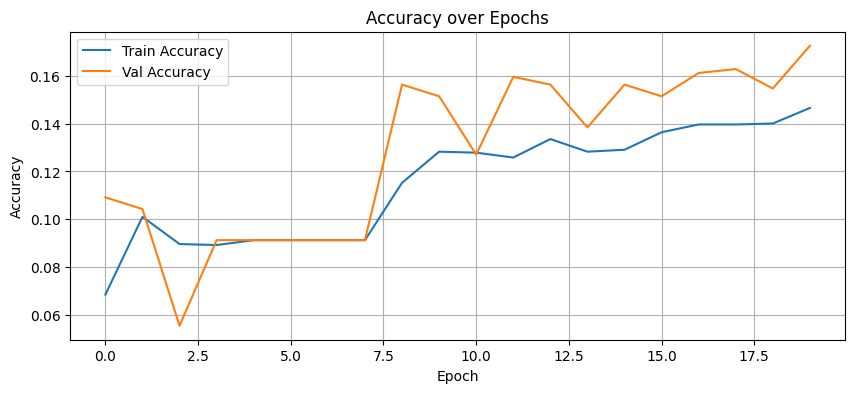

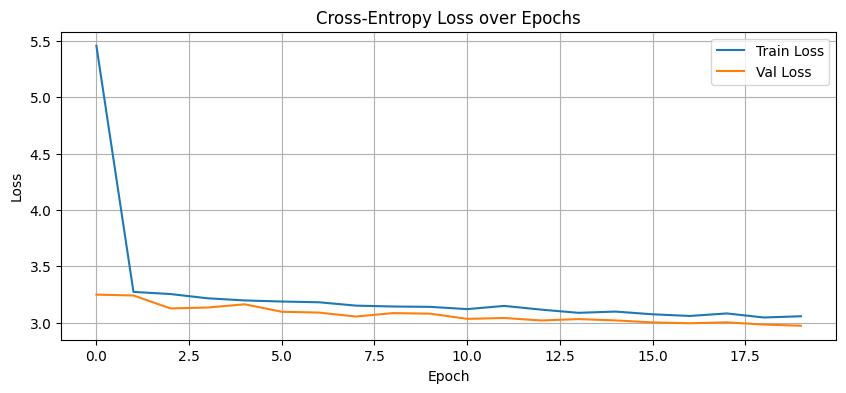

Lowest Train Loss: 3.0452
Lowest Val Loss:   2.9720
Highest Train Accuracy: 14.66%
Highest Val Accuracy:   17.26%


In [21]:
# Accuracy Plot
plt.figure(figsize=(10, 4))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss Plot
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Cross-Entropy Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Summary
print(f"Lowest Train Loss: {min(train_losses):.4f}")
print(f"Lowest Val Loss:   {min(val_losses):.4f}")
print(f"Highest Train Accuracy: {max(train_accuracies)*100:.2f}%")
print(f"Highest Val Accuracy:   {max(val_accuracies)*100:.2f}%")
